In [1]:
import pandas as pd
import pickle
import copy

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from scipy.special import logit
import shap
shap.initjs()

from alibi.explainers import KernelShap
import random
from timeit import default_timer as timer

SEED = 7

In [2]:
from library.lib import *
from library.ml_lib import *
from sklearn.compose import ColumnTransformer

In [3]:
cross_set_dir            =  '/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/datasets/saved_h5/normal/nc_5_smote_1.pickle'
cross_unbalanced_set_dir =  '/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/datasets/saved_h5/normal/nc_5_smote_2.pickle'

perDaten_path            = '/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/'
code_path                = perDaten_path + 'code/'
result_path              = perDaten_path + "results/nested_cross/"
result_shap_path         =  result_path + "shap_values/"

datasets_path            = perDaten_path + "datasets/"

In [4]:
params = {
    "trials" : 1, 
    "n_splits" : 5, 
    "verbose" : 0, 
    "label" : "y", 
    "n_jobs" : 2, 
    "save_results" : False, 
    "test_on_holdout" : True,
    "result_dir" : perDaten_path+"results/cross_splitting/"
}

pipes = [

    Pipeline([
        ("var_th", VarianceThreshold()),
        ("scale0", MinMaxScaler(feature_range=(-1, 1))),
        ("model", GradientBoostingClassifier(random_state=0))
    ]),
    Pipeline([
        ("var_th", VarianceThreshold()),
        ("scale0", MinMaxScaler(feature_range=(-1, 1))),
        ("feature_selection", SelectKBest()), 
        ("model", LinearSVC())
    ]),
    Pipeline([
        ("var_th", VarianceThreshold()),
        ("scale0", MinMaxScaler(feature_range=(-1, 1))),
        ("feature_selection", SelectKBest()), 
        ("model", SVC())
    ])
]


grids = [
    #GradientBoostingClassifier
    {
        "model__max_depth" : [8 ,16,32,40,50], 
        "model__max_features" : ["sqrt", "auto", "log2"],
        "model__n_estimators" : [25, 50,75,100], 
        "model__min_samples_split" : [0.1, 0.3], 
        "model__min_samples_leaf" : [0.3, 0.5]
    },
    #LinearSVC
    {
        #"feature_selection__k" : list(range(1,35,1)),
        "feature_selection__k" : ["all"],
        "model__C"             : [1e-8,1e-6,1e-4,1e-3, 1e-2, 1e-3,1, 10, 1e3, 1e4,1e5,1e6],
        'model__class_weight'  :['balanced'],
    },
    #SVC
    {
        
        #ohne feature selection
        #gamma erweitern
        
        #"feature_selection__k" : list(range(1,35,1)),
        "feature_selection__k" : ["all"],
        "model__kernel" : ["rbf"],
        "model__C" : [1e-8,1e-6,1e-4,1e-3, 1e-2, 1e-3,1, 10, 1e3, 1e4,1e5,1e6],
        #"model__gamma" : [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1, 10, 1e3, 1e4,1e5,1e6],
        "model__gamma" : [1e-8,1e-1,1, 10, 1e3, 1e4,1e5,1e6],
        'model__class_weight'  :['balanced'],
        'model__probability':[True],

        
    }

]

In [5]:
model_names = {
            "GradientBoostingClassifier":"GB",
            "LinearSVC":"SVC-lin",                      #schon binär
            "SVC":"SVC-rbf",                  #2 soll eins werden
           }

In [6]:
data_path = datasets_path+'unbalanced_data.pickle'

with open(data_path, "rb") as input_file:
     Data = pickle.load(input_file)
        
feature_type = Data['list_of_types'][1]

in_dict = Data["in_dict"]
out_dict = Data["out_dict"]
print("feature", feature_type)
label        = 'CESD_min_1'
        
        
Data.keys()
y                    = Data[label]['y']
X                    = Data[label]['Input_datasets'][feature_type]['X']
category_map         = Data[label]['Input_datasets'][feature_type]['category_map']
ordinal_features     = Data[label]['Input_datasets'][feature_type]['ordinal_features']
categorical_features = Data[label]['Input_datasets'][feature_type]['categorical_features'] 
feature_names        = Data[label]['Input_datasets'][feature_type]['feature_names']

print("feature_names ", feature_names)

df = X.iloc[:,ordinal_features]
print("ordinal_features")
print(pd.Series({c: len(df[c].unique()) for c in df}))
print("")

df = X.iloc[:,categorical_features]
print("categorical_features")
print(pd.Series({c: len(df[c].unique()) for c in df}))

feature clinical
feature_names  ['TL_DM', 'hxsmok_a', 's_hxalk_a', 'hxchol_ps', 'TL_VHF_corrected', 'TL_HTN', 'TL_pAVK_corrected', 'TL_Angi_pectoris', 'TL_Herzinfarkt', 'depent_before_stroke', 's_aktiv_1y', 'pmrrsr_1a', 'pmrrdr_1a']
ordinal_features
pmrrsr_1a    93
pmrrdr_1a    60
dtype: int64

categorical_features
TL_DM                   2
hxsmok_a                4
s_hxalk_a               3
hxchol_ps               3
TL_VHF_corrected        2
TL_HTN                  2
TL_pAVK_corrected       2
TL_Angi_pectoris        2
TL_Herzinfarkt          3
depent_before_stroke    3
s_aktiv_1y              3
dtype: int64


In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

my_dpi = 400
smote = SMOTE(0.9)
scorers = ["balanced_accuracy"]
search_results_df  = pd.DataFrame()
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error


In [8]:
Data['labels']

['scbig_a',
 'scbigb_1y',
 'mRS_a_neu',
 'scrank_1y',
 'scmmg',
 'TICS_sum_1',
 'CESD_min_1',
 'surv_y_all_3',
 'surv_y_all_1']

In [9]:
out_dict

{'Barthel Index': 'scbig_a',
 'Barthel Index after 1 year': 'scbigb_1y',
 'mRS': 'mRS_a_neu',
 'mRS after 1 year': 'scrank_1y',
 'MMSE': 'scmmg',
 'TICS-M': 'TICS_sum_1',
 'CES-D': 'CESD_min_1',
 'Survival ≤ 3 years': 'surv_y_all_3',
 'Survival ≤ 1 year': 'surv_y_all_1'}

In [10]:
dict((y,x) for x,y in out_dict.items())

{'scbig_a': 'Barthel Index',
 'scbigb_1y': 'Barthel Index after 1 year',
 'mRS_a_neu': 'mRS',
 'scrank_1y': 'mRS after 1 year',
 'scmmg': 'MMSE',
 'TICS_sum_1': 'TICS-M',
 'CESD_min_1': 'CES-D',
 'surv_y_all_3': 'Survival ≤ 3 years',
 'surv_y_all_1': 'Survival ≤ 1 year'}

In [11]:
N_explain = 10

for pipe, grid in zip(pipes, grids):
    model_name = str(type(pipe["model"]).__name__ )
    
    Model_name = model_names[model_name]
    print(model_name)

GradientBoostingClassifier
LinearSVC
SVC


Model_name SVC-lin
feature_type  all
Label  Barthel Index
cross_iteration:  0
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index_all0_beeswarm.png


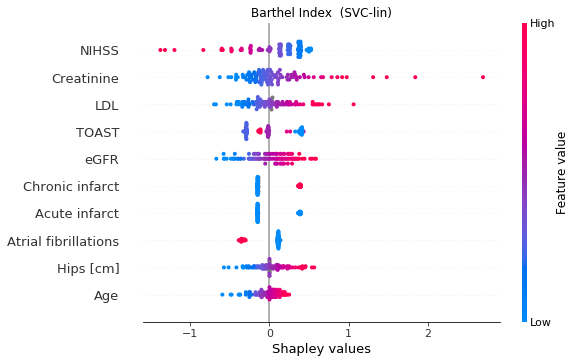

cross_iteration:  1
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index_all1_beeswarm.png


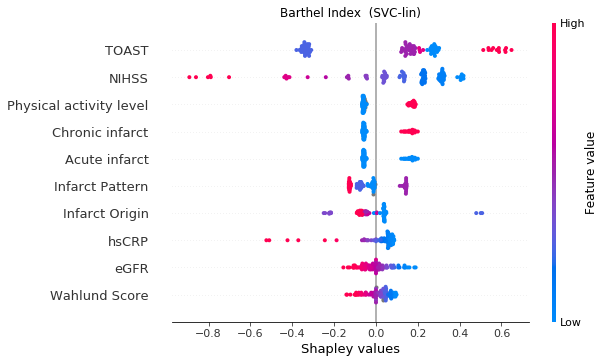

cross_iteration:  2
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index_all2_beeswarm.png


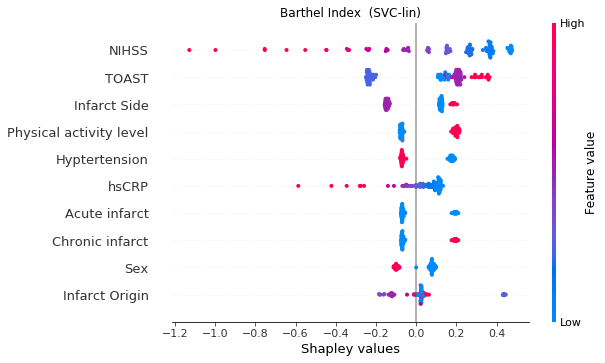

cross_iteration:  3
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index_all3_beeswarm.png


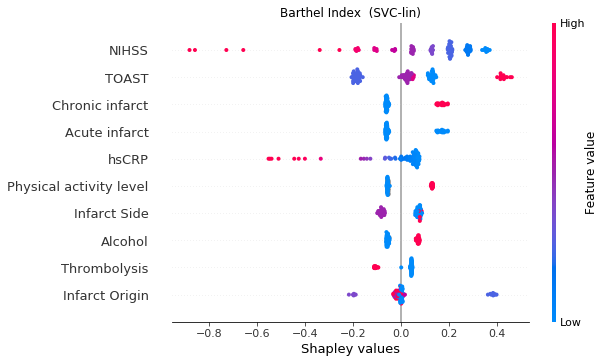

cross_iteration:  4
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index_all4_beeswarm.png


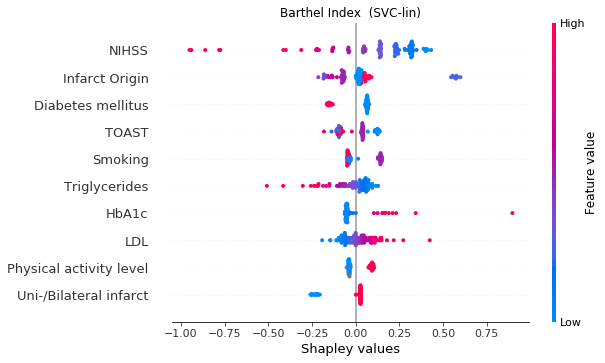

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index_all_bar.png


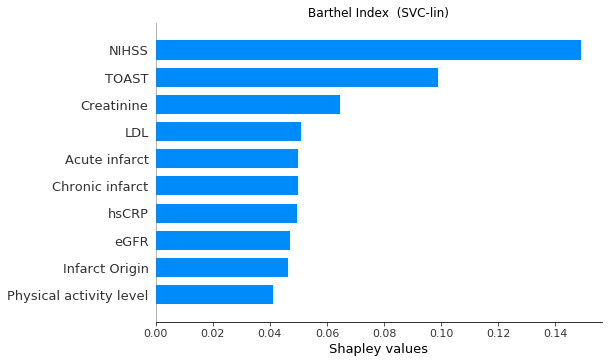

Model_name SVC-lin
feature_type  all
Label  Barthel Index after 1 year
cross_iteration:  0
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index after 1 year_all0_beeswarm.png


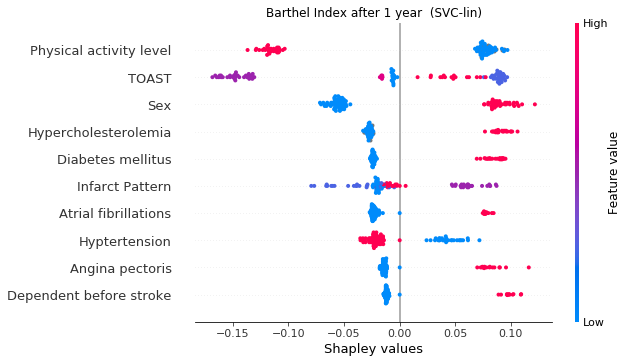

cross_iteration:  1
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index after 1 year_all1_beeswarm.png


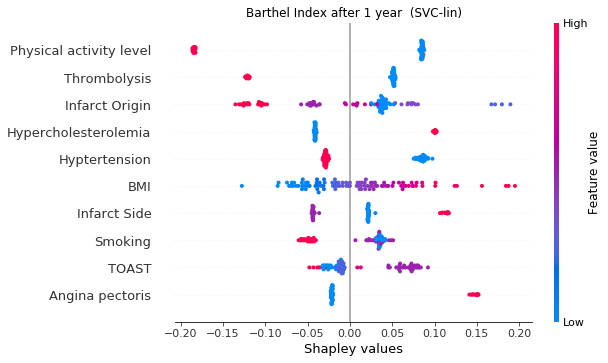

cross_iteration:  2
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index after 1 year_all2_beeswarm.png


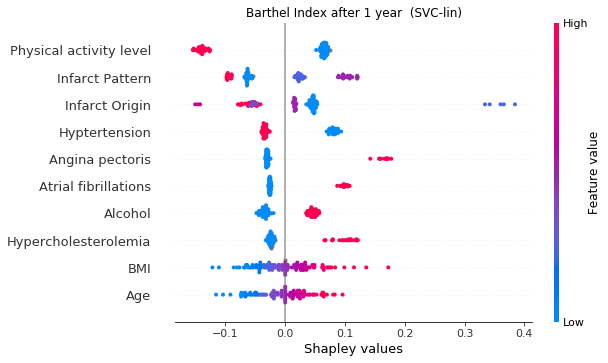

cross_iteration:  3
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index after 1 year_all3_beeswarm.png


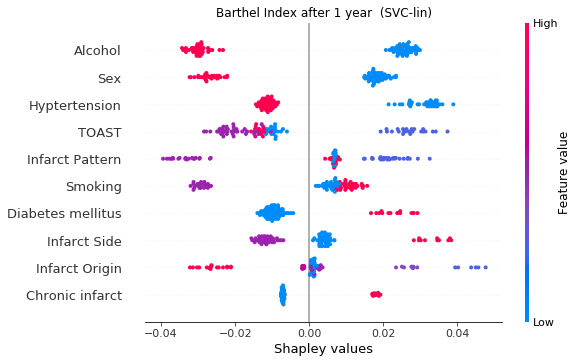

cross_iteration:  4
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index after 1 year_all4_beeswarm.png


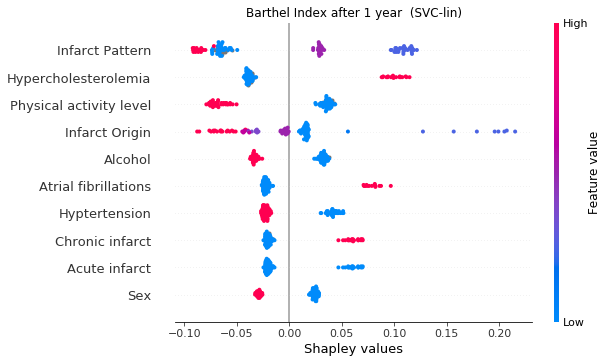

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_Barthel Index after 1 year_all_bar.png


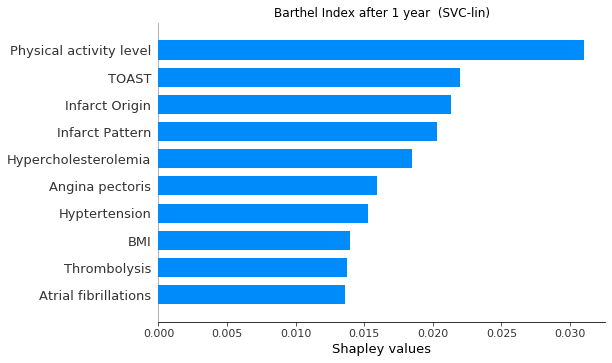

Model_name SVC-lin
feature_type  all
Label  mRS
cross_iteration:  0
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

save name : /home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/results/nested_cross/shap_values/LinearSVC_mRS_all0_beeswarm.png


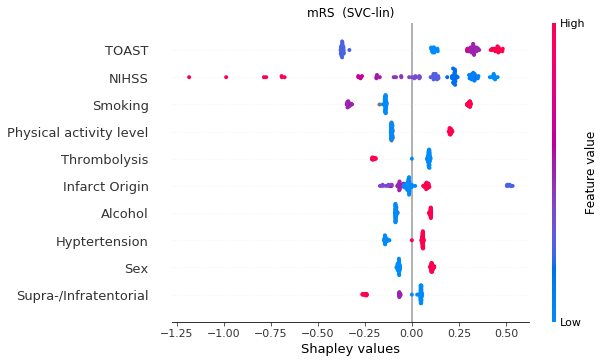

cross_iteration:  1
fitted


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [15]:
N_explain = 50

for pipe, grid in zip(pipes, grids):
    model_name = str(type(pipe["model"]).__name__ )
    
    Model_name = model_names[model_name]
    if not Model_name == 'GB': continue

    for label in Data['labels']:
        for feature_type in Data['list_of_types']:
            
            if not feature_type == "all": continue
               
            #rename labels and models
            Model_name = model_names[model_name]
            Label = dict((y,x) for x,y in out_dict.items())[label]
            
            print("Model_name" , Model_name)
            print("feature_type ", feature_type)
            print("Label " , Label)
            
            y                    = Data[label]['y']
            X                    = Data[label]['Input_datasets'][feature_type]['X']
            category_map         = Data[label]['Input_datasets'][feature_type]['category_map']
            ordinal_features     = Data[label]['Input_datasets'][feature_type]['ordinal_features']
            categorical_features = Data[label]['Input_datasets'][feature_type]['categorical_features'] 
            feature_names        = Data[label]['Input_datasets'][feature_type]['feature_names']
            
            shap_all = []
            #outer cross validation loop
            for cross_iteration,(train_ix, test_ix) in enumerate(cv_outer.split(X,y)):
                
                #preprocess
                #categorical shapley values
                #https://docs.seldon.io/projects/alibi/en/stable/examples/kernel_shap_adult_lr.html
                print("cross_iteration: ", cross_iteration)
                simple_ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                                      ('scaler', StandardScaler())])

                iterativ_ordinal_transformer = Pipeline(steps=[('imputer', IterativeImputer(verbose=0,
                                                                                         max_iter=5,
                                                                                         tol=1e-10,
                                                                                         imputation_order='roman', min_value = 0)),
                                                        ('scaler', StandardScaler())])
                
                categorical_transformer   = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),                   
                                    # ('onehot', OneHotEncoder(handle_unknown='ignore'))])   
                                    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

                preprocessor_train = ColumnTransformer(transformers=[('num', iterativ_ordinal_transformer,
                                                                             ordinal_features),
                                                                     ('cat', categorical_transformer,
                                                                             categorical_features)])

                preprocessor_test  = ColumnTransformer(transformers=[('num', simple_ordinal_transformer, 
                                                                             ordinal_features),
                                                                     ('cat', categorical_transformer, 
                                                                             categorical_features)])

                X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
                y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

                X_train         = X_train.drop(columns = ["sex_index","ID"])  
                X_test          = X_test.drop(columns = ["sex_index","ID"]) 

                preprocessor_train           = preprocessor_train.fit(X_train)
                preprocessor_test            = preprocessor_test.fit(X_train)
                

                num_feats_names,cat_feats_names,perm_feat_names,\
                cat_feat_start,feat_enc_dim,fts = get_featnames(preprocessor_train,
                                                                                categorical_features,
                                                                                ordinal_features,
                                                                                feature_names)
                
                X_train_proc = preprocessor_train.transform(X_train)
                
                
                #train 
                cv = tuple(StratifiedKFold(n_splits=5, shuffle=True).split(X_train_proc, y_train,groups=None))
                gs = GridSearchCV(pipe, grid, cv=cv, scoring=scorers[0],\
                                return_train_score=True, 
                                verbose=0,
                                n_jobs=2, 
                                pre_dispatch="2*n_jobs")

                gs = gs.fit(X_train_proc, y_train)
                print("fitted")

                #try test 
                try_loop = 0

                while(try_loop == 0):
                    try:
                        X_test_sample = X_test.sample(n=N_explain)
                        X_explain = pd.concat([X_train.sample(n=N_explain), X_test_sample])
                        X_explain_proc = preprocessor_test.transform(X_explain.values)
                        try_loop = 1
                    except:
                        try_loop = 0

                # Select only 100 examples for the background dataset to speedup computation
                start_example_idx = 0
                stop_example_idx = 100
                background_data = slice(start_example_idx, stop_example_idx)
                
                if Model_name == 'GB': 
                    predict_fn = lambda x: gs.best_estimator_.predict_proba(x)
                else:
                    calibrated_svc = CalibratedClassifierCV(gs.best_estimator_,
                        method='sigmoid',  #sigmoid will use Platt's scaling. Refer to documentation for other methods.
                        cv=3) 
                    calibrated_svc.fit(X_train_proc, y_train)
                    predict_fn = lambda x: calibrated_svc.predict_proba(x)
                
                lr_explainer = KernelShap(predict_fn, link='logit', feature_names=perm_feat_names)
                lr_explainer.fit(X_train_proc[background_data, :])

                explanation = lr_explainer.explain(X_explain_proc,
                                                   summarise_result=True,
                                                   cat_vars_start_idx=cat_feat_start,
                                                   cat_vars_enc_dim=feat_enc_dim,
                                                  )
                #concat shapley values
                shap_all.append(explanation.shap_values[1])
                perm_X_explain, _ = permute_columns(X_explain.values, feature_names, perm_feat_names)

                renamed_feat_names = [[dict((y,x) for x,y in in_dict.items())][0][feat_name] \
                  for feat_name in perm_feat_names]
                
                max_disp_sum = sum(sum(np.abs(explanation.shap_values[0]) > 0.01) > 0 )
                
                if max_disp_sum > 10:
                    max_disp_sum = 10
                    
                title = Label+ "  ("+ Model_name+")"
                    
                save_name = result_shap_path+model_name+"_"+Label+"_"+feature_type+str(cross_iteration)+"_beeswarm.png"  
                
                plt.title(title)
                shap.summary_plot(explanation.shap_values[1], 
                                  perm_X_explain,
                                  renamed_feat_names,
                                  max_display=max_disp_sum,
                                  show =False)
                
                plt.xlabel("Shapley values")
                
                #plt.savefig(save_name, 
                #            dpi=200,
                #            bbox_inches ="tight",
                #            optimize =True,
                #            pad_inches=0)
                
                print("save name :" , save_name)
                plt.show()
                plt.clf() 
                 # modelname in Klammern
            
                #X_explain_proc = preprocessor_test.transform(X_explain)
                #X_test_proc = preprocessor_test.transform(X_test.iloc[:,:])
                
                
        plt.title(title)
        save_name = result_shap_path+model_name+"_"+Label+"_"+feature_type+"_bar.png"
        shap.summary_plot(np.mean(shap_all, axis=0),
                          renamed_feat_names, 
                          plot_type="bar",
                          max_display=max_disp_sum,
                          show =False)
        plt.xlabel("Shapley values")

        #plt.savefig(save_name, 
        #            dpi=200,
        #            bbox_inches ="tight",
        #            optimize =True,
        #            pad_inches=0)


        print("save name :" , save_name)
        plt.show()
        plt.clf() 
        break